In [5]:
import argparse
import time
import os
from random import sample
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import QED
from rdkit.Chem import AllChem
from rdkit import DataStructs

from scaffold_constrained_model import scaffold_constrained_RNN
from train_agent import train_agent
from data_structs import Vocabulary, Experience
from scoring_functions import get_scoring_function
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
import pandas as pd
import torch

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
# Loading trained model and appropriate vocabulary

run_experiments = False

voc = Vocabulary(init_from_file="data/DistributionLearningBenchmark/Voc")
    
Agent = scaffold_constrained_RNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))


<bound method Module.state_dict of MultiGRU(
  (embedding): Embedding(50, 128)
  (gru_1): GRUCell(128, 512)
  (gru_2): GRUCell(512, 512)
  (gru_3): GRUCell(512, 512)
  (linear): Linear(in_features=512, out_features=50, bias=True)
)>


# 1. Distribution learning benchmarks

# Generating results

In [6]:
#
# calculation of synthetic accessibility score as described in:
#
# Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
# Peter Ertl and Ansgar Schuffenhauer
# Journal of Cheminformatics 1:8 (2009)
# http://www.jcheminf.com/content/1/1/8
#
# several small modifications to the original paper are included
# particularly slightly different formula for marocyclic penalty
# and taking into account also molecule symmetry (fingerprint density)
#
# for a set of 10k diverse molecules the agreement between the original method
# as implemented in PipelinePilot and this implementation is r2 = 0.97
#
# peter ertl & greg landrum, september 2013
#


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pickle

import math
from collections import defaultdict

import os.path as op

_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:

    data = pickle.load(gzip.open('fpscores.pkl.gz'))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()

    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                               2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore


def processMols(mols):
    print('smiles\tName\tsa_score')
    for i, m in enumerate(mols):
        if m is None:
            continue

        s = calculateScore(m)

        smiles = Chem.MolToSmiles(m)
        print(smiles + "\t" + m.GetProp('_Name') + "\t%3f" % s)


#
#  Copyright (c) 2013, Novartis Institutes for BioMedical Research Inc.
#  All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#     * Neither the name of Novartis Institutes for BioMedical Research Inc.
#       nor the names of its contributors may be used to endorse or promote
#       products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [7]:
def int_diversity(smiles):
    if len(smiles)==0:
        return 0.5
    diversity = 0
    for s in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 4)
        for m in smiles:
            query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), 4)
            diversity += DataStructs.TanimotoSimilarity(query_fp, fp) 
    diversity /= len(smiles)**2
    return 1 - diversity

def validity_and_uniqueness_assessement(pattern= "c1c(*)cc2c(c1)c(*)ccn2", refs = None, n_tryouts=5000, save_path=None):
    n_valid = 0
    n_unique = 0
    logP = []
    MW = []
    qed_list = []
    SAS = []
    HD_list = []
    HA_list = []
    smiles = []
        
    seqs, agent_likelihood, entropy = Agent.sample(pattern, batch_size=n_tryouts)
        #seqs, agent_likelihood, entropy = Agent.sample(1)
    for seq in seq_to_smiles(seqs, voc):
        mol = Chem.MolFromSmiles(seq)
    
        if mol:
            n_valid += 1

            if Chem.MolToSmiles(mol) not in smiles:
                smiles.append(Chem.MolToSmiles(mol))
                n_unique += 1
            try:
                SAS.append(calculateScore(mol))
                MW.append(Descriptors.ExactMolWt(mol))
                logP.append(Descriptors.MolLogP(mol))
                qed_list.append(QED.qed(mol))
                HA_list.append(Lipinski.NumHAcceptors(mol))
                HD_list.append(Lipinski.NumHDonors(mol))
            except:
                pass
    
    if save_path:
        
        df_summary = pd.DataFrame(columns = ["Scaffold", "Percentage valid molecules", "Percentage unique molecules"])
        df_summary["Scaffold"] = [pattern]
        df_summary["Percentage valid molecules"] = [n_valid/n_tryouts]
        df_summary["Percentage unique molecules"] = [n_unique/n_valid]

        df_details = pd.DataFrame(columns = ["Molecular weight",
                                    "Calculated log P", "Synthetizability Accessibility Score (SAS)", "Quantitative Estimate of Drug-likeness (QED)",
                                    "Number of H bonds acceptors", "Number of H bonds donors"])
        df_details["Molecular weight"] = MW
        df_details["Calculated log P"] = logP
        df_details["Synthetizability Accessibility Score (SAS)"] = SAS
        df_details["Quantitative Estimate of Drug-likeness (QED)"] = qed_list
        df_details["Number of H bonds acceptors"] = HA_list
        df_details["Number of H bonds donors"] = HD_list
        
        df_details.to_csv(save_path + "_details.csv")
        df_summary.to_csv(save_path + "_summary.csv")
    return n_valid/n_tryouts, n_unique/n_valid, MW, logP, SAS, qed_list, HA_list, HD_list

In [8]:
patterns = ['N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3',
 'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
 'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
 'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
 'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
 'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
 'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)',
 'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
 'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',
 'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2',
 'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
 'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',
 'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
 'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',
 'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
 'C=C(*)C(=O)CC(=O)C=C(*)',
 'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)']

drd2_patterns = ['c1(*)cccc2c1OCC(N(*)C(*))C2',
                 'O=C(*)NCC=CCN1CCN(*)CC1',
                 'C1(=O)N(*)CCN(*)1',
                 'O=C(NCC1N(*)CCC1)c1c(*)ccc(*)c1O(*)',
                 'O=C(NCCN1CCN(*)CC1)c1cc(Br)c2ccccc2c1(*)']

In [9]:
if run_experiments:
    for i, pattern in enumerate(patterns):
        val, uniques, mw, logp, synthetic_as, qeds, _, _ = validity_and_uniqueness_assessement(pattern, n_tryouts=10000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_surechembl')

    for i, pattern in enumerate(drd2_patterns):
        val, uniques, mw, logp, synthetic_as, qeds, _, _ = validity_and_uniqueness_assessement(pattern, n_tryouts=10000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_drd2')

In [10]:
validity = []
unicities = []
SAS = []
QEDs = []
MW = []
logP = []
HBA = []
HBD = []
scaffold = []
for i in range(17):
    df = pd.read_csv('data/results_distribution_learning_benchmark/scaffold_' + str(i) + '_surechembl_summary.csv')
    scaffold.append(df['Scaffold'][0])
    validity.append(df["Percentage valid molecules"][0])
    unicities.append(df["Percentage unique molecules"][0])
    df = pd.read_csv('data/results_distribution_learning_benchmark/scaffold_' + str(i) + '_surechembl_details.csv')
    SAS.extend(df["Synthetizability Accessibility Score (SAS)"])
    QEDs.extend(df["Quantitative Estimate of Drug-likeness (QED)"])
    MW.extend(df["Molecular weight"])
    logP.extend(df["Calculated log P"])
    HBA.extend(df["Number of H bonds acceptors"])
    HBD.extend(df["Number of H bonds donors"])


# Plotting validity and unicity

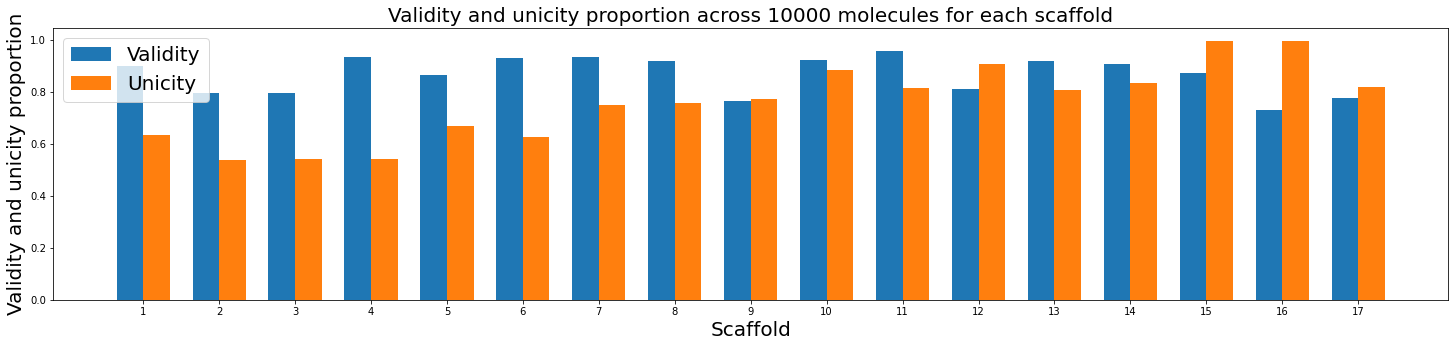

In [11]:
labels = [str(i+1) for i in range(len(validity))]

counts = []
for scaff in scaffold:
    counts.append(scaff.count('*'))
indexes = np.argsort(np.array(counts))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(25,5))
rects1 = ax.bar(x - width/2, np.array(validity)[indexes], width, label='Validity')
rects2 = ax.bar(x + width/2, np.array(unicities)[indexes], width, label='Unicity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validity and unicity proportion',fontsize=20)
ax.set_xlabel('Scaffold',fontsize=20)

ax.set_title('Validity and unicity proportion across 10000 molecules for each scaffold', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(prop={'size': 20})


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

#plt.show()

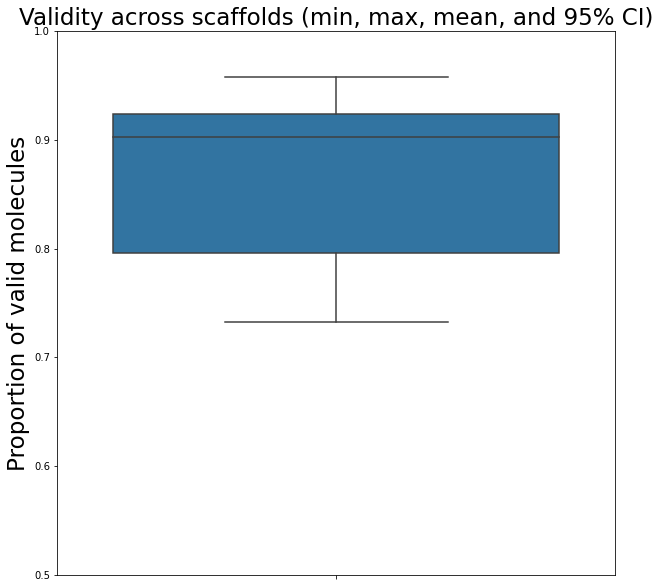

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=10)

ax.set_title('Validity across scaffolds (min, max, mean, and 95% CI)', fontsize=23)
ax.set_ylabel("Proportion of valid molecules",fontsize=23)
ax = sns.boxplot(x=validity, orient='v')
ax.set_ylim(0.5, 1)
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
# plt.show()

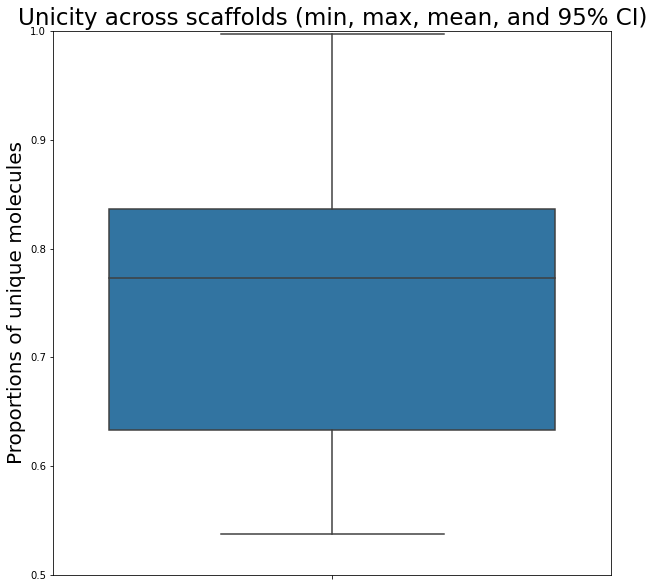

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=10)

ax.set_title('Unicity across scaffolds (min, max, mean, and 95% CI)', fontsize=23)
ax.set_ylabel("Proportions of unique molecules", fontsize=20)
ax = sns.boxplot(x=unicities, orient='v')
ax.set_ylim(0.5, 1)
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
# plt.show()

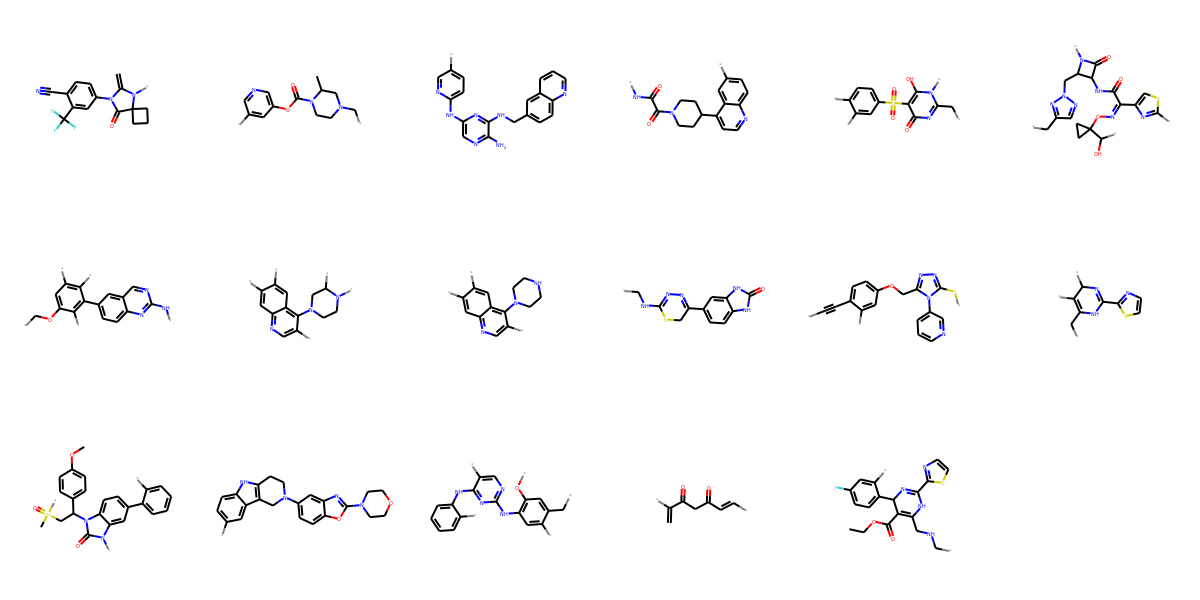

In [14]:
from rdkit.Chem import Draw
from rdkit import Chem

Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in ["N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3",
            'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
            'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
            'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
            'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
            'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
            'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)', #6
            'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
            'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',#8
            'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2', #10
            'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
            'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',#12
            'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
            'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',#14
            'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
            'C=C(*)C(=O)CC(=O)C=C(*)', #16
            'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)']], molsPerRow=6)

# Plotting distributions

In [15]:
# Getting molecules from SureChEMBL ("validation set" in the paper)
suppl = Chem.SDMolSupplier('data/SureChEMBL/200323_SureChemBL_dataset_636.sdf')
smiles = []
series = []
comparisons = []
for i, mol in enumerate(suppl):
    series.append(mol.GetProp('Series_Name'))
    smiles.append(Chem.MolToSmiles(mol))
    comparisons.append(mol)
    
logP_Chembl_original = []
MW_Chembl_original = []
qed_list_Chembl_original = []
SAS_Chembl_original = []
HBA_ChEMBL_original = []
HBD_ChEMBL_original = []
for mol in comparisons:    
    try:
        SAS_Chembl_original.append(calculateScore(mol))
        MW_Chembl_original.append(Descriptors.ExactMolWt(mol))
        logP_Chembl_original.append(Descriptors.MolLogP(mol))
        qed_list_Chembl_original.append(QED.qed(mol))
        HBA_ChEMBL_original.append(Lipinski.NumHAcceptors(mol))
        HBD_ChEMBL_original.append(Lipinski.NumHDonors(mol))
    except:
        pass

In [16]:
# Getting a subset from ChEMBL ("training set" in the paper)
suppl = Chem.SmilesMolSupplier('data/ChEMBL_filtered',delimiter='\t')
count = 0
comparisons_chembl = []
for mol in suppl:
    comparisons.append(mol)
    count += 1
    if count>10000:
        break

    
logP_Chembl = []
MW_Chembl = []
qed_list_Chembl = []
SAS_Chembl = []
HBA_ChEMBL = []
HBD_ChEMBL = []

for mol in comparisons:   
    try:
        SAS_Chembl.append(calculateScore(mol))
        MW_Chembl.append(Descriptors.ExactMolWt(mol))
        logP_Chembl.append(Descriptors.MolLogP(mol))
        qed_list_Chembl.append(QED.qed(mol))
        HBA_ChEMBL.append(Lipinski.NumHAcceptors(mol))
        HBD_ChEMBL.append(Lipinski.NumHDonors(mol))
    except:
        pass

RDKit WARNING: [22:57:37] WARNING: no name column found on line 1
RDKit WARNING: [22:57:37] WARNING: no name column found on line 2
RDKit WARNING: [22:57:37] WARNING: no name column found on line 3
RDKit WARNING: [22:57:37] WARNING: no name column found on line 4
RDKit WARNING: [22:57:37] WARNING: no name column found on line 5
RDKit WARNING: [22:57:37] WARNING: no name column found on line 6
RDKit WARNING: [22:57:37] WARNING: no name column found on line 7
RDKit WARNING: [22:57:37] WARNING: no name column found on line 8
RDKit WARNING: [22:57:37] WARNING: no name column found on line 9
RDKit WARNING: [22:57:37] WARNING: no name column found on line 10
RDKit WARNING: [22:57:37] WARNING: no name column found on line 11
RDKit WARNING: [22:57:37] WARNING: no name column found on line 12
RDKit WARNING: [22:57:37] WARNING: no name column found on line 13
RDKit WARNING: [22:57:37] WARNING: no name column found on line 14
RDKit WARNING: [22:57:37] WARNING: no name column found on line 15
RDKi

RDKit WARNING: [22:57:38] WARNING: no name column found on line 2574
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2575
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2576
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2577
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2578
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2579
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2580
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2581
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2582
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2583
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2584
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2585
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2586
RDKit WARNING: [22:57:38] WARNING: no name column found on line 2587
RDKit WARNING: [22:57:38] WARNING:

RDKit WARNING: [22:57:38] WARNING: no name column found on line 3573
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3574
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3575
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3576
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3577
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3578
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3579
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3580
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3581
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3582
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3583
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3584
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3585
RDKit WARNING: [22:57:38] WARNING: no name column found on line 3586
RDKit WARNING: [22:57:38] WARNING:

RDKit WARNING: [22:57:38] WARNING: no name column found on line 4572
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4573
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4574
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4575
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4576
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4577
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4578
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4579
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4580
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4581
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4582
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4583
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4584
RDKit WARNING: [22:57:38] WARNING: no name column found on line 4585
RDKit WARNING: [22:57:38] WARNING:

RDKit WARNING: [22:57:39] WARNING: no name column found on line 5571
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5572
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5573
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5574
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5575
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5576
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5577
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5578
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5579
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5580
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5581
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5582
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5583
RDKit WARNING: [22:57:39] WARNING: no name column found on line 5584
RDKit WARNING: [22:57:39] WARNING:

RDKit WARNING: [22:57:39] WARNING: no name column found on line 6570
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6571
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6572
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6573
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6574
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6575
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6576
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6577
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6578
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6579
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6580
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6581
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6582
RDKit WARNING: [22:57:39] WARNING: no name column found on line 6583
RDKit WARNING: [22:57:39] WARNING:

RDKit WARNING: [22:57:39] WARNING: no name column found on line 7569
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7570
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7571
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7572
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7573
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7574
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7575
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7576
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7577
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7578
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7579
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7580
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7581
RDKit WARNING: [22:57:39] WARNING: no name column found on line 7582
RDKit WARNING: [22:57:39] WARNING:

RDKit WARNING: [22:57:40] WARNING: no name column found on line 8568
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8569
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8570
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8571
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8572
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8573
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8574
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8575
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8576
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8577
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8578
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8579
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8580
RDKit WARNING: [22:57:40] WARNING: no name column found on line 8581
RDKit WARNING: [22:57:40] WARNING:

RDKit WARNING: [22:57:40] WARNING: no name column found on line 9567
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9568
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9569
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9570
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9571
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9572
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9573
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9574
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9575
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9576
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9577
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9578
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9579
RDKit WARNING: [22:57:40] WARNING: no name column found on line 9580
RDKit WARNING: [22:57:40] WARNING:

Text(0.5, 0, 'QED')

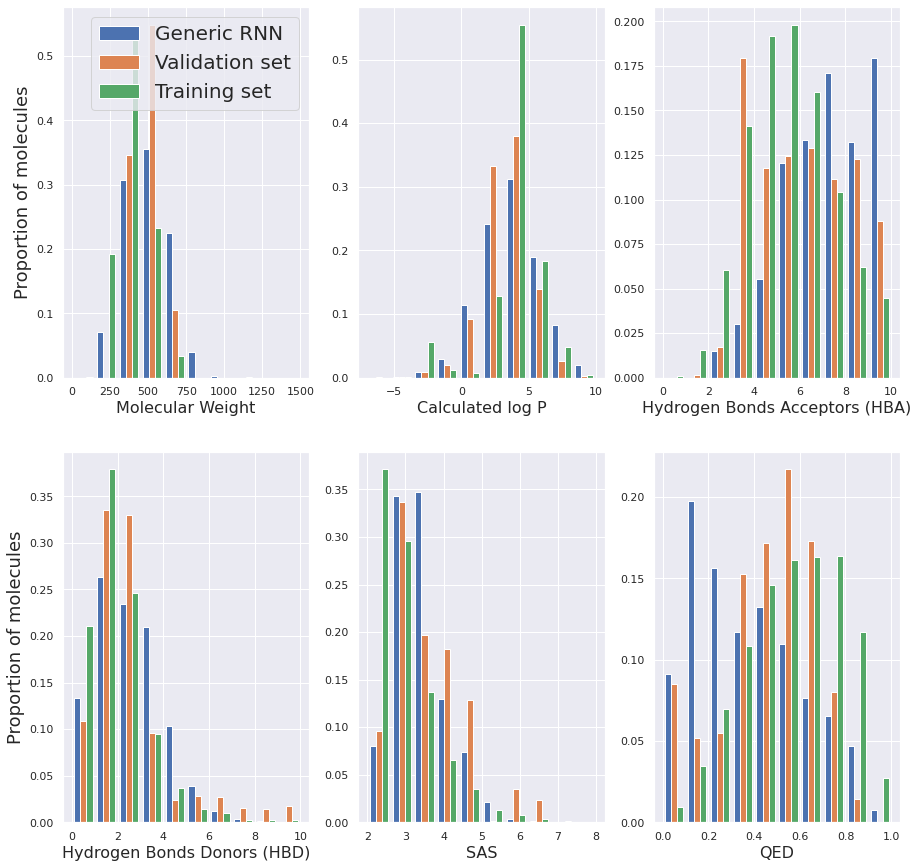

In [19]:
sns.set()
plt.figure(figsize=(15, 15))

plt.subplot(231)
plt.hist([MW, MW_Chembl_original, MW_Chembl], weights=[np.ones(len(MW)) / len(MW),
                                                       np.ones(len(MW_Chembl_original)) / len(MW_Chembl_original),
                                                       np.ones(len(MW_Chembl)) / len(MW_Chembl),], range= (0,1500), label=['Generic RNN', 'Validation set', 'Training set'])
plt.legend(loc=1, prop={'size': 20})

plt.ylabel('Proportion of molecules', fontsize=18)
plt.xlabel('Molecular Weight', fontsize=16)

plt.subplot(232)
plt.hist([logP, logP_Chembl, logP_Chembl_original], weights=[np.ones(len(logP)) / len(logP),
                                                       np.ones(len(logP_Chembl)) / len(logP_Chembl),
                                                       np.ones(len(logP_Chembl_original)) / len(logP_Chembl_original),], range= (-7,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.xlabel('Calculated log P', fontsize=16)


plt.subplot(233)
plt.hist([HBA, HBA_ChEMBL_original, HBA_ChEMBL], weights=[np.ones(len(HBA)) / len(HBA),
                                                       np.ones(len(HBA_ChEMBL_original)) / len(HBA_ChEMBL_original),
                                                       np.ones(len(HBA_ChEMBL)) / len(HBA_ChEMBL),], range= (0,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.xlabel('Hydrogen Bonds Acceptors (HBA)', fontsize=16)

plt.subplot(234)
plt.hist([HBD, HBD_ChEMBL_original, HBD_ChEMBL], weights=[np.ones(len(HBD)) / len(HBD),
                                                       np.ones(len(HBD_ChEMBL_original)) / len(HBD_ChEMBL_original),
                                                       np.ones(len(HBD_ChEMBL)) / len(HBD_ChEMBL),], range= (0,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.ylabel('Proportion of molecules', fontsize=18)
plt.xlabel('Hydrogen Bonds Donors (HBD)', fontsize=16)

plt.subplot(235)
plt.hist([SAS, SAS_Chembl_original, SAS_Chembl], weights=[np.ones(len(SAS)) / len(SAS),
                                                       np.ones(len(SAS_Chembl_original)) / len(SAS_Chembl_original),
                                                       np.ones(len(SAS_Chembl)) / len(SAS_Chembl),], range= (2,8), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.xlabel('SAS', fontsize=16)

plt.subplot(236)
plt.hist([QEDs, qed_list_Chembl_original, qed_list_Chembl], weights=[np.ones(len(QEDs)) / len(QEDs),
                                                       np.ones(len(qed_list_Chembl_original)) / len(qed_list_Chembl_original),
                                                       np.ones(len(qed_list_Chembl)) / len(qed_list_Chembl),], range= (0,1), label=['Generic RNN', 'Validation set', 'Training set'])

plt.xlabel('QED', fontsize=16)
